In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from transformers import BeitForImageClassification, BeitConfig
from peft import LoraConfig, get_peft_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
data_dir = r'C:\Users\Demyd Zaborskyi\.cache\kagglehub\datasets\itsahmad\indoor-scenes-cvpr-2019\versions\1\indoorCVPR_09\Images'

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

num_classes = len(full_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 67


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 4070


In [4]:
class_names = full_dataset.classes

In [5]:
model_lora = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')
model_lora.config.num_labels = num_classes
model_lora.classifier = nn.Linear(model_lora.classifier.in_features, num_classes)

# LoRA

In [6]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type="IMAGE_CLASSIFICATION"
)

model_lora = get_peft_model(model_lora, lora_config)

for name, param in model_lora.named_parameters():
    if "lora_" not in name and "classifier" not in name:
        param.requires_grad = False

print("\nParameters to be fine-tuned (LoRA):")
for name, param in model_lora.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

model_lora.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_lora = optim.Adam(filter(lambda p: p.requires_grad, model_lora.parameters()), lr=1e-4)




Parameters to be fine-tuned (LoRA):
base_model.model.beit.encoder.layer.0.attention.attention.query.lora_A.default.weight torch.Size([8, 768])
base_model.model.beit.encoder.layer.0.attention.attention.query.lora_B.default.weight torch.Size([768, 8])
base_model.model.beit.encoder.layer.0.attention.attention.value.lora_A.default.weight torch.Size([8, 768])
base_model.model.beit.encoder.layer.0.attention.attention.value.lora_B.default.weight torch.Size([768, 8])
base_model.model.beit.encoder.layer.1.attention.attention.query.lora_A.default.weight torch.Size([8, 768])
base_model.model.beit.encoder.layer.1.attention.attention.query.lora_B.default.weight torch.Size([768, 8])
base_model.model.beit.encoder.layer.1.attention.attention.value.lora_A.default.weight torch.Size([8, 768])
base_model.model.beit.encoder.layer.1.attention.attention.value.lora_B.default.weight torch.Size([768, 8])
base_model.model.beit.encoder.layer.2.attention.attention.query.lora_A.default.weight torch.Size([8, 768])


# Adapter Multiscale

In [7]:
class DynamicMultiscaleAdapter(nn.Module):
    def __init__(self, input_dim, adapter_dim=64, scales=[1, 2, 3]):
        super(DynamicMultiscaleAdapter, self).__init__()
        self.adapters = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, adapter_dim),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(adapter_dim, input_dim)
            ) for _ in scales
        ])
        self.attention = nn.Linear(input_dim, len(scales))

    def forward(self, x):
        adapted_outputs = [adapter(x) for adapter in self.adapters]
        adapted = torch.stack(adapted_outputs, dim=2)

        scores = self.attention(x).softmax(dim=-1)  
        scores = scores.unsqueeze(-1)  

        adapted = (adapted * scores).sum(dim=2)  
        return x + adapted

class BeitWithCustomAdapter(nn.Module):
    def __init__(self, base_model, adapter_dim=64, scales=[1, 2, 3]):
        super(BeitWithCustomAdapter, self).__init__()
        self.base_model = base_model
        self.num_classes = base_model.config.num_labels
        self.hidden_size = base_model.config.hidden_size

        # Add custom adapter to each transformer block
        for idx, block in enumerate(self.base_model.beit.encoder.layer):
            block.custom_adapter = DynamicMultiscaleAdapter(self.hidden_size, adapter_dim, scales)

        # Replace classifier
        self.base_model.classifier = nn.Linear(self.hidden_size, self.num_classes)

    def forward(self, pixel_values):
        outputs = self.base_model.beit(
            pixel_values=pixel_values,
            output_hidden_states=False,
            return_dict=True
        )
        x = outputs.last_hidden_state

        # Apply custom adapters
        for idx, block in enumerate(self.base_model.beit.encoder.layer):
            x = block.custom_adapter(x)

        x = self.base_model.beit.layernorm(x)
        pooled_output = x[:, 0]
        logits = self.base_model.classifier(pooled_output)

        return logits

base_beit_custom = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')
base_beit_custom.config.num_labels = num_classes
model_custom_adapter = BeitWithCustomAdapter(base_beit_custom, adapter_dim=64, scales=[1, 2, 3])

for name, param in model_custom_adapter.named_parameters():
    if "custom_adapter" not in name and "classifier" not in name:
        param.requires_grad = False

print("\nParameters to be fine-tuned (Custom Adapter):")
for name, param in model_custom_adapter.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

model_custom_adapter.to(device)

criterion_custom = nn.CrossEntropyLoss()
optimizer_custom = optim.Adam(filter(lambda p: p.requires_grad, model_custom_adapter.parameters()), lr=1e-4)



Parameters to be fine-tuned (Custom Adapter):
base_model.beit.encoder.layer.0.custom_adapter.adapters.0.0.weight torch.Size([64, 768])
base_model.beit.encoder.layer.0.custom_adapter.adapters.0.0.bias torch.Size([64])
base_model.beit.encoder.layer.0.custom_adapter.adapters.0.3.weight torch.Size([768, 64])
base_model.beit.encoder.layer.0.custom_adapter.adapters.0.3.bias torch.Size([768])
base_model.beit.encoder.layer.0.custom_adapter.adapters.1.0.weight torch.Size([64, 768])
base_model.beit.encoder.layer.0.custom_adapter.adapters.1.0.bias torch.Size([64])
base_model.beit.encoder.layer.0.custom_adapter.adapters.1.3.weight torch.Size([768, 64])
base_model.beit.encoder.layer.0.custom_adapter.adapters.1.3.bias torch.Size([768])
base_model.beit.encoder.layer.0.custom_adapter.adapters.2.0.weight torch.Size([64, 768])
base_model.beit.encoder.layer.0.custom_adapter.adapters.2.0.bias torch.Size([64])
base_model.beit.encoder.layer.0.custom_adapter.adapters.2.3.weight torch.Size([768, 64])
base_mo

# Adapter Tuning

In [8]:
class Adapter(nn.Module):
    def __init__(self, input_dim, adapter_dim=64):
        super(Adapter, self).__init__()
        self.linear_down = nn.Linear(input_dim, adapter_dim)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.linear_up = nn.Linear(adapter_dim, input_dim)

    def forward(self, x):
        down = self.linear_down(x)
        activated = self.activation(down)
        dropped = self.dropout(activated)
        up = self.linear_up(dropped)
        return x + up  # Residual connection

class BeitWithAdapters(nn.Module):
    def __init__(self, base_model, adapter_dim=64):
        super(BeitWithAdapters, self).__init__()
        self.base_model = base_model
        self.num_classes = base_model.config.num_labels
        self.hidden_size = base_model.config.hidden_size

        for idx, block in enumerate(self.base_model.beit.encoder.layer):
            block.adapter = Adapter(self.hidden_size, adapter_dim)

        self.base_model.classifier = nn.Linear(self.hidden_size, self.num_classes)

    def forward(self, pixel_values):
        outputs = self.base_model.beit(
            pixel_values=pixel_values,
            output_hidden_states=False,
            return_dict=True
        )
        x = outputs.last_hidden_state

        for idx, block in enumerate(self.base_model.beit.encoder.layer):
            x = block.adapter(x)

        x = self.base_model.beit.layernorm(x)
        pooled_output = x[:, 0]
        logits = self.base_model.classifier(pooled_output)

        return logits


In [9]:
base_beit_adapter = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')
base_beit_adapter.config.num_labels = num_classes
model_adapter = BeitWithAdapters(base_beit_adapter, adapter_dim=64)

for name, param in model_adapter.named_parameters():
    if "adapter" not in name and "classifier" not in name:
        param.requires_grad = False

print("\nParameters to be fine-tuned (Adapter Tuning):")
for name, param in model_adapter.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

model_adapter.to(device)

criterion_adapter = nn.CrossEntropyLoss()
optimizer_adapter = optim.Adam(filter(lambda p: p.requires_grad, model_adapter.parameters()), lr=1e-4)



Parameters to be fine-tuned (Adapter Tuning):
base_model.beit.encoder.layer.0.adapter.linear_down.weight torch.Size([64, 768])
base_model.beit.encoder.layer.0.adapter.linear_down.bias torch.Size([64])
base_model.beit.encoder.layer.0.adapter.linear_up.weight torch.Size([768, 64])
base_model.beit.encoder.layer.0.adapter.linear_up.bias torch.Size([768])
base_model.beit.encoder.layer.1.adapter.linear_down.weight torch.Size([64, 768])
base_model.beit.encoder.layer.1.adapter.linear_down.bias torch.Size([64])
base_model.beit.encoder.layer.1.adapter.linear_up.weight torch.Size([768, 64])
base_model.beit.encoder.layer.1.adapter.linear_up.bias torch.Size([768])
base_model.beit.encoder.layer.2.adapter.linear_down.weight torch.Size([64, 768])
base_model.beit.encoder.layer.2.adapter.linear_down.bias torch.Size([64])
base_model.beit.encoder.layer.2.adapter.linear_up.weight torch.Size([768, 64])
base_model.beit.encoder.layer.2.adapter.linear_up.bias torch.Size([768])
base_model.beit.encoder.layer.3.

# Training/Evaluating Functions

In [10]:
import warnings
warnings.filterwarnings("ignore", message="Torch was not compiled with flash attention")

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, model_name='model'):
    best_val_acc = 0.0
    total_training_time = 0.0  # Variable to store total training time

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time measurement for the epoch

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(pixel_values=inputs)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(pixel_values=inputs)
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs

                loss = criterion(logits, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(logits, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total

        end_time = time.time()  # End time measurement for the epoch
        epoch_time = end_time - start_time
        total_training_time += epoch_time

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f} | "
              f"Time: {epoch_time:.2f}s")

        # Save the best model
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), f'best_{model_name}.pth')

    print(f"Best Validation Accuracy for {model_name}: {best_val_acc:.4f}")
    print(f"Total Training Time for {model_name}: {total_training_time:.2f}s")
    return total_training_time  # Return total training time

def evaluate_model(model, test_loader, device, class_names, model_name='model'):
    model.eval()
    all_preds = []
    all_labels = []
    inference_times = []  # List to store inference times

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            start_time = time.time()  # Start time measurement for inference
            outputs = model(pixel_values=inputs)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            end_time = time.time()  # End time measurement for inference

            _, preds = torch.max(logits, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            inference_times.append(end_time - start_time)

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    avg_inference_time = sum(inference_times) / len(inference_times)

    print(f"\nTest Metrics for {model_name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Average Inference Time per Batch: {avg_inference_time:.4f}s")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return acc, precision, recall, f1, avg_inference_time, cm

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


# Training

In [11]:
print("\n=== Training model with LoRA ===")
training_time_lora = train_model(
    model=model_lora,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_lora,
    device=device,
    num_epochs=10,
    model_name='model_lora_beit'
)


=== Training model with LoRA ===
Epoch 1/10 | Train Loss: 3.6012 | Train Acc: 0.1707 | Val Loss: 2.7211 | Val Acc: 0.3880 | Time: 96.65s
Epoch 2/10 | Train Loss: 2.4551 | Train Acc: 0.4232 | Val Loss: 2.0571 | Val Acc: 0.5058 | Time: 96.40s
Epoch 3/10 | Train Loss: 1.9826 | Train Acc: 0.5263 | Val Loss: 1.7074 | Val Acc: 0.5728 | Time: 96.58s
Epoch 4/10 | Train Loss: 1.7052 | Train Acc: 0.5948 | Val Loss: 1.4729 | Val Acc: 0.6325 | Time: 96.61s
Epoch 5/10 | Train Loss: 1.5132 | Train Acc: 0.6459 | Val Loss: 1.3224 | Val Acc: 0.6714 | Time: 96.53s
Epoch 6/10 | Train Loss: 1.3611 | Train Acc: 0.6824 | Val Loss: 1.1885 | Val Acc: 0.7098 | Time: 96.64s
Epoch 7/10 | Train Loss: 1.2439 | Train Acc: 0.7117 | Val Loss: 1.0974 | Val Acc: 0.7307 | Time: 96.51s
Epoch 8/10 | Train Loss: 1.1509 | Train Acc: 0.7423 | Val Loss: 1.0300 | Val Acc: 0.7405 | Time: 96.45s
Epoch 9/10 | Train Loss: 1.0600 | Train Acc: 0.7608 | Val Loss: 0.9685 | Val Acc: 0.7627 | Time: 96.74s
Epoch 10/10 | Train Loss: 0.99


=== Evaluating model with LoRA ===

Test Metrics for LoRA:
Accuracy: 0.7636
Precision: 0.7768
Recall: 0.7636
F1-Score: 0.7495
Average Inference Time per Batch: 0.1040s


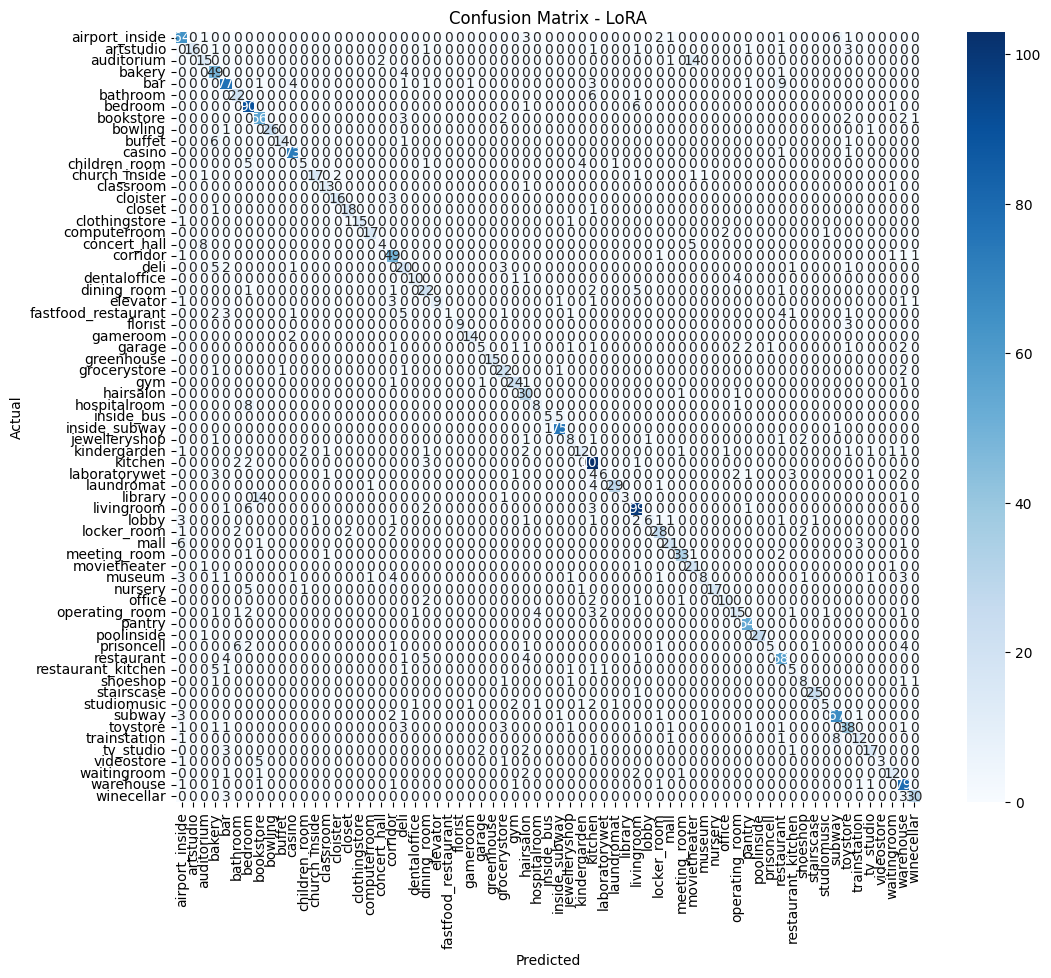


LoRA Model - Total Parameters: 86108419, Trainable Parameters: 294912


In [12]:
# Оцінка моделі з LoRA
print("\n=== Evaluating model with LoRA ===")
model_lora.load_state_dict(torch.load('best_model_lora_beit.pth'))
model_lora.to(device)
acc_lora, precision_lora, recall_lora, f1_lora, inference_time_lora, cm_lora = evaluate_model(
    model=model_lora,
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    model_name='LoRA'
)

# Підрахунок параметрів моделі з LoRA
total_params_lora, trainable_params_lora = count_parameters(model_lora)
print(f"\nLoRA Model - Total Parameters: {total_params_lora}, Trainable Parameters: {trainable_params_lora}")

In [13]:
print("\n=== Training model with Custom Adapter ===")
training_time_custom_adapter = train_model(
    model=model_custom_adapter,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_custom,
    optimizer=optimizer_custom,
    device=device,
    num_epochs=20,
    model_name='model_custom_adapter_beit'
)


=== Training model with Custom Adapter ===
Epoch 1/20 | Train Loss: 41.3186 | Train Acc: 0.0267 | Val Loss: 9.9044 | Val Acc: 0.0495 | Time: 70.18s
Epoch 2/20 | Train Loss: 11.8829 | Train Acc: 0.0290 | Val Loss: 6.4319 | Val Acc: 0.0585 | Time: 70.29s
Epoch 3/20 | Train Loss: 6.3703 | Train Acc: 0.0499 | Val Loss: 4.7864 | Val Acc: 0.1161 | Time: 70.29s
Epoch 4/20 | Train Loss: 4.6796 | Train Acc: 0.0984 | Val Loss: 3.8537 | Val Acc: 0.1515 | Time: 70.42s
Epoch 5/20 | Train Loss: 3.9390 | Train Acc: 0.1582 | Val Loss: 3.4073 | Val Acc: 0.1980 | Time: 75.41s
Epoch 6/20 | Train Loss: 3.4773 | Train Acc: 0.2178 | Val Loss: 2.8457 | Val Acc: 0.3342 | Time: 75.91s
Epoch 7/20 | Train Loss: 3.1200 | Train Acc: 0.2717 | Val Loss: 2.5317 | Val Acc: 0.4149 | Time: 76.42s
Epoch 8/20 | Train Loss: 2.7934 | Train Acc: 0.3257 | Val Loss: 2.2713 | Val Acc: 0.4370 | Time: 75.95s
Epoch 9/20 | Train Loss: 2.5454 | Train Acc: 0.3755 | Val Loss: 2.0987 | Val Acc: 0.4686 | Time: 75.43s
Epoch 10/20 | Trai


=== Evaluating model with Custom Adapter ===

Test Metrics for Custom Adapter:
Accuracy: 0.7350
Precision: 0.7538
Recall: 0.7350
F1-Score: 0.7177
Average Inference Time per Batch: 0.1013s


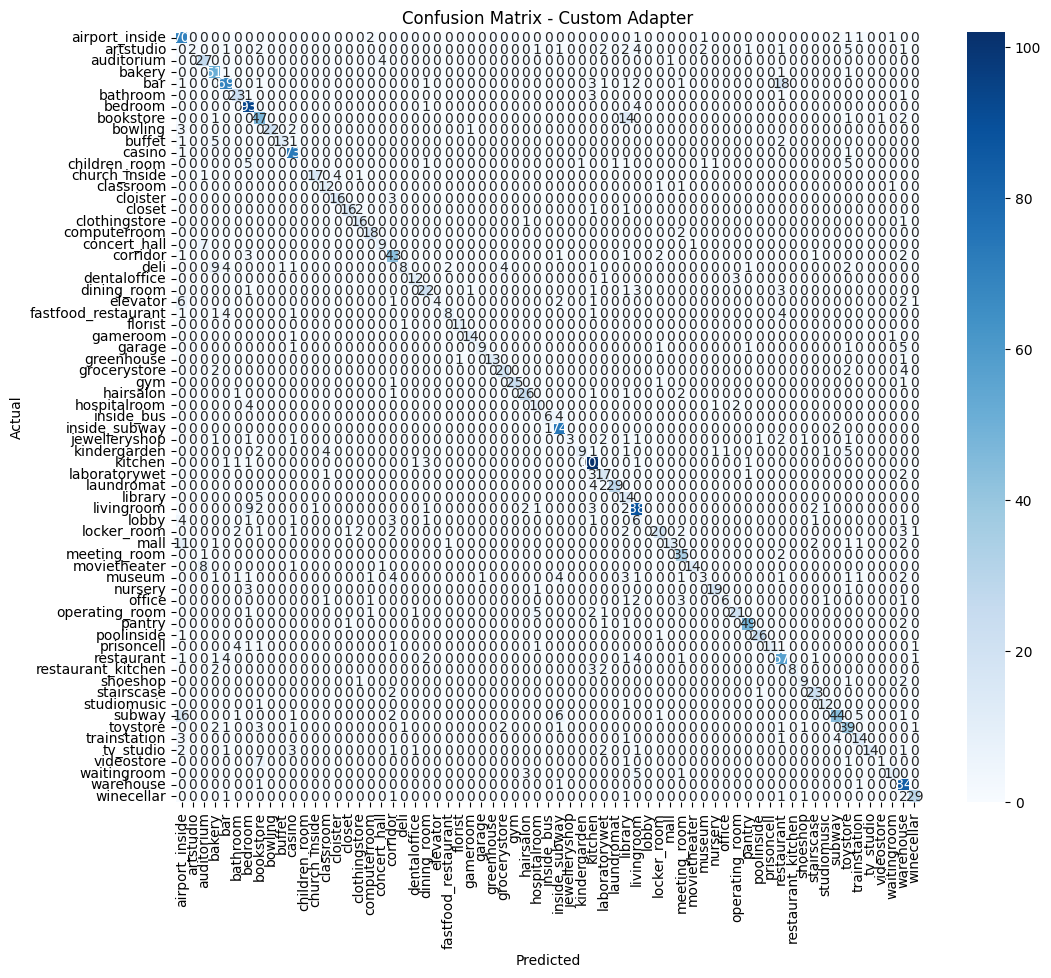


Custom Adapter Model - Total Parameters: 89410087, Trainable Parameters: 3648103


In [14]:
print("\n=== Evaluating model with Custom Adapter ===")
model_custom_adapter.load_state_dict(torch.load('best_model_custom_adapter_beit.pth'))
model_custom_adapter.to(device)
acc_custom_adapter, precision_custom_adapter, recall_custom_adapter, f1_custom_adapter, inference_time_custom_adapter, cm_custom_adapter = evaluate_model(
    model=model_custom_adapter,
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    model_name='Custom Adapter'
)

total_params_custom_adapter, trainable_params_custom_adapter = count_parameters(model_custom_adapter)
print(f"\nCustom Adapter Model - Total Parameters: {total_params_custom_adapter}, Trainable Parameters: {trainable_params_custom_adapter}")

In [15]:
# Тренування моделі з Adapter Tuning
print("\n=== Training model with Adapter Tuning ===")
training_time_adapter = train_model(
    model=model_adapter,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_adapter,
    optimizer=optimizer_adapter,
    device=device,
    num_epochs=20,
    model_name='model_adapter_beit'
)


=== Training model with Adapter Tuning ===
Epoch 1/20 | Train Loss: 27.3979 | Train Acc: 0.0264 | Val Loss: 6.4884 | Val Acc: 0.0572 | Time: 58.07s
Epoch 2/20 | Train Loss: 6.5849 | Train Acc: 0.0573 | Val Loss: 3.7647 | Val Acc: 0.1763 | Time: 57.92s
Epoch 3/20 | Train Loss: 4.2521 | Train Acc: 0.1320 | Val Loss: 3.2015 | Val Acc: 0.2655 | Time: 58.24s
Epoch 4/20 | Train Loss: 3.4225 | Train Acc: 0.2222 | Val Loss: 2.6884 | Val Acc: 0.3278 | Time: 58.08s
Epoch 5/20 | Train Loss: 2.8837 | Train Acc: 0.3152 | Val Loss: 2.1834 | Val Acc: 0.4648 | Time: 58.11s
Epoch 6/20 | Train Loss: 2.4803 | Train Acc: 0.3849 | Val Loss: 1.8917 | Val Acc: 0.5382 | Time: 58.10s
Epoch 7/20 | Train Loss: 2.2015 | Train Acc: 0.4368 | Val Loss: 1.7452 | Val Acc: 0.5561 | Time: 58.07s
Epoch 8/20 | Train Loss: 1.9724 | Train Acc: 0.4882 | Val Loss: 1.5115 | Val Acc: 0.6039 | Time: 58.07s
Epoch 9/20 | Train Loss: 1.7994 | Train Acc: 0.5174 | Val Loss: 1.4880 | Val Acc: 0.5847 | Time: 58.13s
Epoch 10/20 | Train


=== Evaluating model with Adapter Tuning ===

Test Metrics for Adapter Tuning:
Accuracy: 0.7623
Precision: 0.7941
Recall: 0.7623
F1-Score: 0.7551
Average Inference Time per Batch: 0.0997s


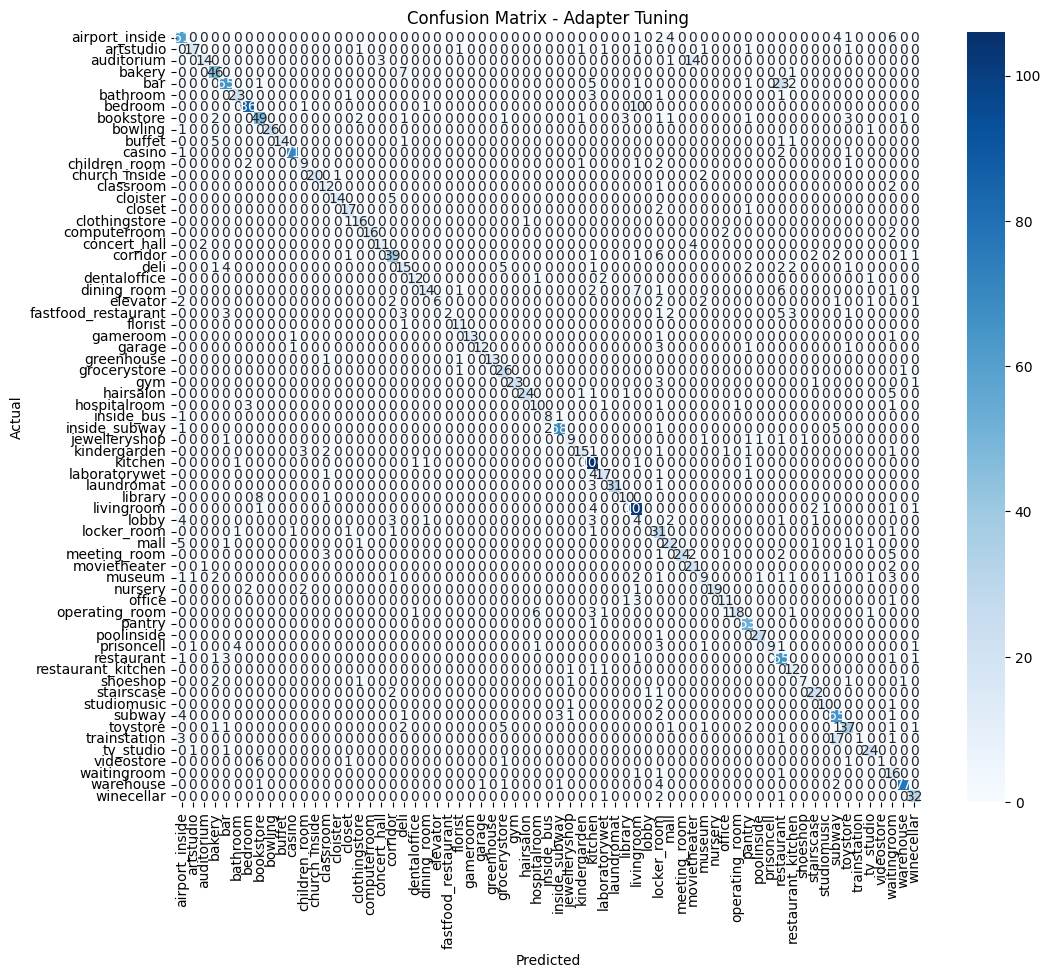


Adapter Tuning Model - Total Parameters: 87003139, Trainable Parameters: 1241155


In [16]:
print("\n=== Evaluating model with Adapter Tuning ===")
model_adapter.load_state_dict(torch.load('best_model_adapter_beit.pth'))
model_adapter.to(device)
acc_adapter, precision_adapter, recall_adapter, f1_adapter, inference_time_adapter, cm_adapter = evaluate_model(
    model=model_adapter,
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    model_name='Adapter Tuning'
)

total_params_adapter, trainable_params_adapter = count_parameters(model_adapter)
print(f"\nAdapter Tuning Model - Total Parameters: {total_params_adapter}, Trainable Parameters: {trainable_params_adapter}")

In [17]:
# Створення таблиці з результатами
data = {
    'Model': ['LoRA', 'Custom Adapter', 'Adapter Tuning'],
    'Accuracy': [acc_lora, acc_custom_adapter, acc_adapter],
    'Precision': [precision_lora, precision_custom_adapter, precision_adapter],
    'Recall': [recall_lora, recall_custom_adapter, recall_adapter],
    'F1-Score': [f1_lora, f1_custom_adapter, f1_adapter],
    'Training Time (s)': [training_time_lora, training_time_custom_adapter, training_time_adapter],
    'Inference Time (s)': [inference_time_lora, inference_time_custom_adapter, inference_time_adapter],
    'Total Params': [total_params_lora, total_params_custom_adapter, total_params_adapter],
    'Trainable Params': [trainable_params_lora, trainable_params_custom_adapter, trainable_params_adapter],
}

df_results = pd.DataFrame(data)
print("\nPEFT comparative analysis:")
print(df_results)



PEFT comparative analysis:
            Model  Accuracy  Precision    Recall  F1-Score  Training Time (s)  \
0            LoRA  0.763551   0.776760  0.763551  0.749521         965.558707   
1  Custom Adapter  0.734955   0.753763  0.734955  0.717662        1491.057261   
2  Adapter Tuning  0.762271   0.794065  0.762271  0.755110        1161.773279   

   Inference Time (s)  Total Params  Trainable Params  
0            0.104022      86108419            294912  
1            0.101326      89410087           3648103  
2            0.099650      87003139           1241155  
